## How to use the t-SNE algorithm on APOGEE globular cluster data. 
##### Steffani Grondin (September 23, 2022)

In [ ]:
%pip install sklearn
%pip install shapely

In [ ]:
%pip install shapely

## Notes for this program

My parameter list is different from Steffani's. My param list is shown below:\\\\
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR', 'SNR', 'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']\\\\

So basically the RA index is 4, DEC index is 5, RV index is 10, and the first chemical abundance is at 13. The chemical abundances follow Steffani's form (e.g. abundance1, abundance1_error, abundance2, abundance2_error, etc.). What I did was make the standardizing step for both tSNE and UMAP take in the index of the first chemical abundance and from there it automatically adds 2 for each chem abundance going up.\\\\

Basically if you use my param_list it'll work. The param_list variable is just a list of strings of the index titles, I have a function somewhere that grabs the data for those indices.\\\\

For each GC, we just need the ra, dec, rhm_deg (rhm depends on dist I think).\\
There are global parameters for all GCs as well, so the parameter list, fov, and chemical abundance starting index.\\\\

LMK if shit dont work and there's probably something I forgot to explain.

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

### Step 1: Load in the clusters

#### Load in selected star cluster
Input RA and DEC and the program will load in all the stars within a $10^o$ by $10^o$ FOV.

In [2]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')
GC_db = pd.read_csv('data/allGCparams_20221201_MASTER.csv', delimiter=',')

In [231]:
apogee_nofilt

,# APOGEE_ID_,GAIAEDR3_SOURCE_ID,RA,DEC,VHELIO_AVG,VERR,VSCATTER,TEFF,TEFF_ERR,LOGG,...,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,CO_FE_ERR,NI_FE_ERR
0,2M00000068+5710233,538028216707715712,0.002850,57.173164,-12.673787,0.029277,0.120245,5035.6900,48.670216,3.416017,...,0.033759,0.069656,0.042801,0.050515,0.090195,0.089703,0.049440,0.058999,0.343203,0.041848
1,2M00000133+5721163,2413929812587459072,0.005558,57.354549,-101.713486,0.066520,0.124213,4972.7134,46.113050,2.402370,...,0.058685,0.086153,0.063082,0.090245,0.064706,0.112211,0.065294,0.068275,0.108428,0.053906
2,2M00000211+6327470,422596679964513792,0.008802,63.463078,-106.631860,0.029086,0.053485,4696.9010,26.962519,2.224851,...,0.050642,0.042538,0.034654,0.037532,0.036766,0.069267,0.027521,0.035404,0.056741,0.034202
3,2M00000233+1452324,422596679964513792,0.009748,14.875667,-38.495186,0.026902,0.053984,4741.8716,80.308900,4.270293,...,0.060693,0.151140,0.072959,0.078504,0.157125,0.098980,0.080651,0.096100,0.065771,0.080449
4,2M00000446+5854329,4689447878791422208,0.018603,58.909149,-48.046894,0.031516,0.031308,4768.0040,25.617336,2.429237,...,0.028433,0.048315,0.029921,0.036650,0.034160,0.078822,0.027886,0.033394,0.040834,0.027055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370055,2M23590214+1435166,1499086767630458368,359.758939,14.587962,-89.050560,0.029243,0.110584,4686.8420,24.910856,2.617401,...,0.031427,0.051146,0.030787,0.042855,0.037961,0.083147,0.038112,0.035892,0.030015,0.029447
370056,2M23593035+1444283,3664628760244345600,359.876459,14.741221,24.179094,0.022893,0.027940,4983.8203,39.287434,2.635594,...,0.043323,0.055856,0.041475,0.038697,0.037045,0.126882,0.048540,0.048035,0.085143,0.037728
370057,2M23593169+5728016,1257993760630656768,359.882046,57.467121,-25.373499,0.027473,0.082224,4716.3580,989.874400,0.209517,...,1.678371,1.008230,0.791015,309663.880000,0.621882,0.623979,0.681815,0.712939,1.286080,0.912791
370058,2M23594776+1524307,1495448135764429440,359.949033,15.408548,-21.232704,0.027778,0.093972,4709.2734,49.365166,2.041033,...,0.071290,0.196804,0.067982,0.067939,0.092466,0.134635,0.097245,0.065816,0.069048,0.064046


In [245]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, fov, df, name):
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov and i <= ra + fov and df['DEC'].values[count] >= dec - fov and df['DEC'].values[count] <= dec + fov:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a 10x10 fov of the GC')

    ra_arr = np.empty(len(stars), dtype=float)
    dec_arr = np.empty(len(stars), dtype=float)
    for count, i in enumerate(stars):
        ra_arr[count] = i['RA']
        dec_arr[count] = i['DEC']

    plt.figure(figsize=(10,10))
    plt.plot(ra_arr, dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.title(name)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.show()
    
    return stars
            

#### Separating list of stars into lists by parameter

In [4]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict
        

#### Separating the dictionary values into a columns list

In [5]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

#### Master GC load function

In [244]:
def master_load(ra, dec, fov, dataset, params, name):
    stars_found = find_cluster_stars(ra, dec, fov, dataset, name)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]
    

### Step 2: Filter the data

#### Filter 1 for data: Removing all stars without PM

In [7]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    #print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

#### Filter 2 for data: Removing all stars that do not have chemical abundances

In [8]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    #print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

#### Filter 3 for data: Removing all duplicate spectra

In [9]:
# changed all indices of 0 to 4 (RA) and 23 to 12 (SNR)
def dup_filter(data_abundancefilter):
    d =  Counter(data_abundancefilter[4])
    #print(d)
    duplicates = [k for k, v in d.items() if v > 1]
    a_list = np.array(range(0, len(duplicates)))
    max_SNR_array = []

    for i in a_list:
        indices = np.where(data_abundancefilter[4] == duplicates[i])
        snr_val = data_abundancefilter[12][indices]
        maximum = max(snr_val)
        # 4 is RA, 12 is SNR
        index_maximum = np.where((data_abundancefilter[4] == duplicates[i]) & (data_abundancefilter[12] == maximum))
        #print(index_maximum[4])
        index_maximum = int(index_maximum[4])
        max_SNR_array.append(index_maximum)

    idx_sort = np.argsort(data_abundancefilter[4])
    sorted_ra_array = data_abundancefilter[4][idx_sort]
    vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count == 1]
    listtest =  np.array(range(0, len(vals)))

    unique_array = []
    for i in listtest:
        unique_val = np.where(vals[i] == data_abundancefilter[4])
        unique_val = int(unique_val[0])
        unique_array.append(unique_val)

    #print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
    #print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))
    
    if len(max_SNR_array) != 0:
        duplicates_filter = np.concatenate((unique_array, max_SNR_array))
        sortedarray = np.sort(duplicates_filter)

        data_duplicatesfilter = []
        for i in data_abundancefilter:
            z = np.array(i)[duplicates_filter]
            data_duplicatesfilter.append(z)

        #print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))
    
    else:
        #print('There were no duplicate spectra.')
        data_duplicatesfilter = data_abundancefilter
    
    return data_duplicatesfilter

#### Filter 4 for data: Removing all low SNR

In [10]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    #print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    #print(data_snrfilter[12])
    return data_snrfilter

#### Master filter function

In [ ]:
def master_filter(GC_dict, GC_cols):
    M3_pm_filter = pm_filter(GC_dict, GC_cols)
    M3_abundance_filter = chem_filter(M3_pm_filter, 13)
    M3_duplicates_filter = dup_filter(M3_abundance_filter)
    M3_SNR_filter = SNR_filter(M3_duplicates_filter)
    
    print('The final amount of stars in our sample is:', len(M3_SNR_filter[0]))
    return M3_SNR_filter

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

# multiply the rhm by fraction * rt / rhm, varying the fraction from 1/rt to 1 and plot for the first 20-30 GCs.

# see how this affects the control group clustering

In [232]:
def control_group(data_filter, ra, dec, rhm_deg, rt_deg):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    print('rhm: {:.2f}\trt: {:.2f}'.format(rhm_deg, rt_deg))
    
    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    # Select stars within 8 * r,hm (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, 8*rhm_deg, ra_filtered, dec_filtered)
    indices_control = np.where(in_halfmass==True)
    
    frac = np.sort(np.linspace(rhm_deg, rt_deg, 5)) / rhm_deg
    #print(frac)
    
    in_halfmass_scale = []
    indices_control_scale = []
    for i in range(len(frac)):
        in_halfmass_scale.append(in_circle(ra, dec, frac[i] * rhm_deg, ra_filtered, dec_filtered))
        indices_control_scale.append(np.where(in_halfmass_scale[i] == True))
    
    #print(len(indices_control_scale))
    '''controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)'''
        
    controlgroup_scale = []
    for i in range(len(indices_control_scale)):
        d = []
        for j in data_filter:
            c = np.array(j)[indices_control_scale[i]]
            d.append(c)
        controlgroup_scale.append(d)


    ''' # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars in our GC control group.".format(len(ra_control)))
    
    # no control stars
    if len(ra_control) == 0:
        return None
    
    else:
        return [indices_control]'''
    
    # Example control group parameters: 
    ra_control = controlgroup_scale[0][0]
    dec_control = controlgroup_scale[0][1]
    
    print('There are', [len(i[0]) for i in indices_control_scale], 'stars in our GC control group for a scale factor of', ['%.2f' %i for i in frac], '*rhm. Using 8*rhm gives', len(indices_control[0]))
    
    # no control stars
    if len(indices_control_scale[0][0]) == 0 and len(indices_control_scale[-1][0]) == 0:
        print('No control stars')
        return [None]
    
    else:
        return [indices_control_scale]

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.


In [85]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pretsne_array = []
    params_arr = []
    
    for key in param_dict:
        pretsne_array.append(data_filter[param_dict[key]])
        params_arr.append(key)
    
    pretsne_array = np.array(pretsne_array)
    
    standardized = []
    
    for i in pretsne_array:
        #print(i)
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #print(mean)
        norm = (i - mean) / sigma
        standardized.append(norm)
        
    #print('The chosen parameters for the ML algorithms were:', params_arr)
    return standardized

Next, we apply the t-SNE algorithm via scikit-learn to reduce the dimensionality of the data from 20-D to 2-D.

In [251]:
def tSNE_alg(standardized_array, indices_control, name):
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardized_array)

    # Run t-SNE on the transposed array:
    tsne_init = TSNE(n_components=2)
    tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX = tsne_2d[:, 0]
    t_SNE_dimY = tsne_2d[:, 1]
    
    #print(len(indices_control))

    # Get t-SNE outputs for control group:
    tsne_dimX_control_list = []
    tsne_dimY_control_list = []
    for i in indices_control:
        tsne_dimX_control_list.append(t_SNE_dimX[i])
        tsne_dimY_control_list.append(t_SNE_dimY[i])
        
    print(t_SNE_dimX)
    
    
    #print('asdasdasdasd', len(tsne_dimX_control_list))
    
    fig, ax = plt.subplots(1, len(indices_control), figsize=(8,6))
    ax.scatter(t_SNE_dimX, t_SNE_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(tsne_dimX_control, tsne_dimY_control, s=45, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
    ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16, loc=1)
    plt.show()
    
    #print('tSNE: Total: ', len(t_SNE_dimX), 'Controls: ', [len(i) for i in tsne_dimX_control_list])
    
    return [t_SNE_dimX, t_SNE_dimY, tsne_dimX_control_list, tsne_dimY_control_list]

In [241]:
def master_tSNE(data_filter, param_dict, indices_control, name):
    standardize = standardize_data(data_filter, param_dict)
    
    return tSNE_alg(standardize, indices_control, name)

#### UMAP function

In [248]:
def master_UMAP(data_filter, param_dict, indices_control, name):
    standardize = standardize_data(data_filter, param_dict)
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(standardize)
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardize)

    # Run t-SNE on the transposed array:
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    umap_dimX = embedding[:, 0]
    umap_dimY = embedding[:, 1]

    # Get t-SNE outputs for control group:
    '''umap_dimX_control = umap_dimX[indices_control]
    umap_dimY_control = umap_dimY[indices_control]'''
    umap_dimX_control_list = []
    umap_dimY_control_list = []
    for i in indices_control:
        umap_dimX_control_list.append(umap_dimX[i])
        umap_dimY_control_list.append(umap_dimY[i])

    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(umap_dimX[0], umap_dimY[0], s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(umap_dimX_control[0] , umap_dimY_control[0], s=45, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("UMAP X-Dimension", fontsize=16)
    ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16)
    plt.show()
    #print('UMAP: Total:',len(umap_dimX),'controls: ', [len(i) for i in umap_dimX_control_list])
    
    return [umap_dimX, umap_dimY, umap_dimX_control_list, umap_dimY_control_list]

Function below is depricated. New function above

#### Choosing which parameters to use for tSNE and UMAP

In [27]:
def ask_input_param(param):
    inp = input('Do you want to keep ' + param + ' as a parameter? [y/n]')
    if inp.lower() == 'y':
        return True
    elif inp.lower() == 'n':
        return False
    else:
        print('Not a valid input, trying again')
        return ask_input_param(param)
        

In [28]:
def choose_params(master_param_dict):
    parameter_dict = {}

    for i in master_param_dict:
        if ask_input_param(i):
            parameter_dict[i] = master_param_dict[i]
            
    return parameter_dict

#### Taking in datasheet and name and automatically getting the parameters

In [29]:
GC_db

,Cluster,RA,DEC,R_Sun,R_GC,Mass,rc,rhm,rt,rho_c,sig0,vesc,RV,pmra,pmdec,RPERI,RAPO,c,Porb
0,NGC_104,6.02379,-72.08131,4.52,7.52,895000.0,0.79,6.30,126.80,4.37,11.9,47.5,-17.45,5.252,-2.551,5.47,7.51,2.205,194.526
1,NGC_288,13.18850,-26.58261,8.99,12.21,93400.0,3.59,8.37,94.86,1.80,3.1,10.8,-44.45,4.164,-5.705,2.03,12.34,1.422,170.579
2,NGC_362,15.80942,-70.84878,8.83,9.62,284000.0,0.40,3.79,91.96,4.67,8.6,31.5,223.12,6.694,-2.535,0.73,11.86,2.362,173.381
3,Whiting_1,30.73750,-3.25278,30.59,35.15,1970.0,2.45,15.49,48.59,0.25,0.4,1.3,-130.41,-0.228,-2.046,21.58,61.96,1.297,2167.024
4,NGC_1261,48.06754,-55.21622,16.40,18.28,182000.0,0.88,5.23,140.39,3.78,5.7,21.8,71.34,1.596,-2.064,1.48,21.09,2.203,277.828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,NGC_7089,323.36258,-0.82325,11.69,10.54,620000.0,0.77,4.77,111.48,4.31,11.0,43.4,-3.78,3.435,-2.159,0.84,18.80,2.161,262.794
155,NGC_7099,325.09213,-23.17986,8.46,7.36,143000.0,0.06,4.99,75.59,5.91,5.6,23.3,-185.19,-0.737,-7.299,1.51,8.56,3.100,124.696
156,Pal_12,326.66180,-21.25261,18.49,15.28,6270.0,3.86,10.52,39.71,0.47,0.7,2.5,27.91,-3.220,-3.333,15.11,51.04,1.012,2175.252
157,Pal_13,346.68519,12.77154,23.48,24.57,3020.0,1.97,16.95,38.56,0.59,0.4,1.7,25.30,1.748,0.104,6.85,57.92,1.292,1097.763


In [30]:
def GC_params(GC_name, db):
    GC = db.loc[db['Cluster'] == GC_name].iloc[0]
    name = GC['Cluster']
    ra = GC['RA']
    dec = GC['DEC']
    mass = GC['Mass']
    rhm = GC['rhm'] # will steff fix this, nobody knows # edit she did
    rt = GC['rt']
    rho_c = GC['rho_c']
    sig0 = GC['sig0']
    vesc = GC['vesc']
    c = GC['c']
    d_Sun = GC['R_Sun'] * 1e3
    rhm_deg = math.degrees(math.atan(rhm / d_Sun))
    rt_deg = math.degrees(math.atan(rt / d_Sun))
    
    return ra, dec, rhm_deg, rt_deg

In [31]:
def input_GC_name(db):
    GC_name = input("Please enter the GC name according to Steff's catalogue:")
    if db.loc[db['Cluster'] == GC_name].empty:
        print('Not a valid name, double check and try again')
        return input_GC_name(db)
    else:
        return GC_name

### Master function (automatic version)

In [243]:
def master_func_auto(GC_name, master_param_dict, fov, db, dataset, params, ML):
    print('\nProcessing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        print("This shit don't got no stars bruh")
        print('Done!\n')
        return [None, None, None, None, None, None, None, None]
    
    else:
        # control grouping
        GC_indices_control_list = control_group(GC_filter_data, ra, dec, rhm_deg, rt_deg)[0]
        
        #print('weqeq', len(GC_indices_control_list))
        #print(GC_indices_control_list)
        
        # no control stars
        if GC_indices_control_list is None:
            print("This shit got no control stars")
            print('Done!\n')
            return [None, None, None, None, None, None, None, None]
        
        else:
            # choosing parameters
            param_dict = master_param_dict

            if ML == 0:
                # tSNEing
                tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control_list, GC_name)

                # UMAPing
                UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control_list, GC_name)

                print('Done!\n')
                return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

            elif ML == 1:
                # tSNEing
                tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control_list)

                print('Done!\n')
                return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

            elif ML == 2:
                # UMAPing
                UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control_list)

                print('Done!\n')
                return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

### Master function (manual version)

In [97]:
def master_func_manual(GC_name, master_param_dict, fov, db, dataset, params, ML):
    print('Processing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    #GC_name = input_GC_name(db)
    ra, dec, rhm_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        print("This shit don't got no stars bruh")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # control grouping
        GC_indices_control = control_group(GC_filter_data, ra, dec, rhm_deg)

        # choosing parameters
        param_dict = choose_params(master_param_dict)

        if ML == 0:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control)

            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

        elif ML == 1:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

        elif ML == 2:
            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control)

            print('Done!\n')
            return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

#### Global GC params

In [34]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36,
                 'RV': RV_index,
                 'PMRA': PMRA_index,
                 'PMDEC': PMDEC_index}


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

#### Reading in from the GC database

In [35]:
GC_db

,Cluster,RA,DEC,R_Sun,R_GC,Mass,rc,rhm,rt,rho_c,sig0,vesc,RV,pmra,pmdec,RPERI,RAPO,c,Porb
0,NGC_104,6.02379,-72.08131,4.52,7.52,895000.0,0.79,6.30,126.80,4.37,11.9,47.5,-17.45,5.252,-2.551,5.47,7.51,2.205,194.526
1,NGC_288,13.18850,-26.58261,8.99,12.21,93400.0,3.59,8.37,94.86,1.80,3.1,10.8,-44.45,4.164,-5.705,2.03,12.34,1.422,170.579
2,NGC_362,15.80942,-70.84878,8.83,9.62,284000.0,0.40,3.79,91.96,4.67,8.6,31.5,223.12,6.694,-2.535,0.73,11.86,2.362,173.381
3,Whiting_1,30.73750,-3.25278,30.59,35.15,1970.0,2.45,15.49,48.59,0.25,0.4,1.3,-130.41,-0.228,-2.046,21.58,61.96,1.297,2167.024
4,NGC_1261,48.06754,-55.21622,16.40,18.28,182000.0,0.88,5.23,140.39,3.78,5.7,21.8,71.34,1.596,-2.064,1.48,21.09,2.203,277.828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,NGC_7089,323.36258,-0.82325,11.69,10.54,620000.0,0.77,4.77,111.48,4.31,11.0,43.4,-3.78,3.435,-2.159,0.84,18.80,2.161,262.794
155,NGC_7099,325.09213,-23.17986,8.46,7.36,143000.0,0.06,4.99,75.59,5.91,5.6,23.3,-185.19,-0.737,-7.299,1.51,8.56,3.100,124.696
156,Pal_12,326.66180,-21.25261,18.49,15.28,6270.0,3.86,10.52,39.71,0.47,0.7,2.5,27.91,-3.220,-3.333,15.11,51.04,1.012,2175.252
157,Pal_13,346.68519,12.77154,23.48,24.57,3020.0,1.97,16.95,38.56,0.59,0.4,1.7,25.30,1.748,0.104,6.85,57.92,1.292,1097.763


In [36]:
GC_name_list = GC_db.loc[:, 'Cluster']
GC_stars_dict = {}

In [237]:
GC_name_list

0        NGC_104
1        NGC_288
2        NGC_362
3      Whiting_1
4       NGC_1261
         ...    
154     NGC_7089
155     NGC_7099
156      Pal_12 
157       Pal_13
158     NGC_7492
Name: Cluster, Length: 159, dtype: object

In [37]:
GC_ra_list = GC_db.loc[:, 'RA']
GC_dec_list = GC_db.loc[:, 'DEC']

In [38]:
#GC_stars_dict[GC_name_list[0]] = master_func(GC_name_list[0], all_param_dict, fov, GC_db, apogee_nofilt, param_list, ML_index)

In [39]:
import time

In [211]:
start = time.time()

for count, i in enumerate(GC_name_list[:30]):
    GC_stars_dict[i] = master_func_auto(i, all_param_dict, fov, GC_db, apogee_nofilt, param_list, ML_index)
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')


Processing: NGC_104
467 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 467
rhm: 0.08	rt: 1.61
There are [155, 165, 170, 178, 185] stars in our GC control group for a scale factor of ['12.52', '14.42', '16.32', '18.22', '20.12'] *rhm. Using 8*rhm gives 112
Done!


Processing: NGC_288
293 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 287
rhm: 0.05	rt: 0.60
There are [84, 110, 125, 144, 155] stars in our GC control group for a scale factor of ['11.33', '13.19', '15.04', '16.89', '18.75'] *rhm. Using 8*rhm gives 60
Done!


Processing: NGC_362
1218 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 1215
rhm: 0.02	rt: 0.60
There are [61, 66, 71, 88, 104] stars in our GC control group for a scale factor of ['24.26', '28.36', '32.46', '36.56', '40.66'] *rhm. Using 8*rhm gives 25
Done!


Processing: Whiting_1
1202 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 1187
rhm: 0.03	rt: 0.0

There are [184, 200, 217, 229, 239] stars in our GC control group for a scale factor of ['20.07', '22.06', '24.05', '26.04', '28.02'] *rhm. Using 8*rhm gives 115
Done!

that shit took 4.215667923291524 mins



Processing: NGC_4833
101 stars in a 10x10 fov of the GC


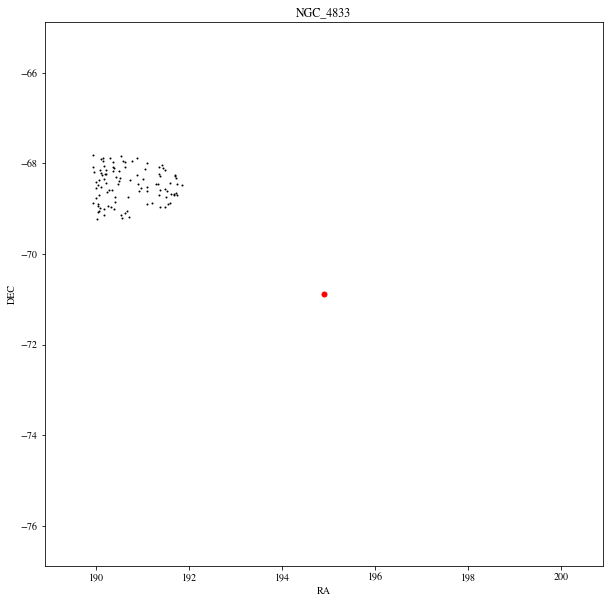


The final amount of stars in our sample is: 101
rhm: 0.04	rt: 0.71
There are [0, 0, 0, 0, 0] stars in our GC control group for a scale factor of ['1.00', '4.96', '8.92', '12.88', '16.84'] *rhm. Using 8*rhm gives 0
No control stars
This shit got no control stars
Done!


Processing: NGC_5024
592 stars in a 10x10 fov of the GC


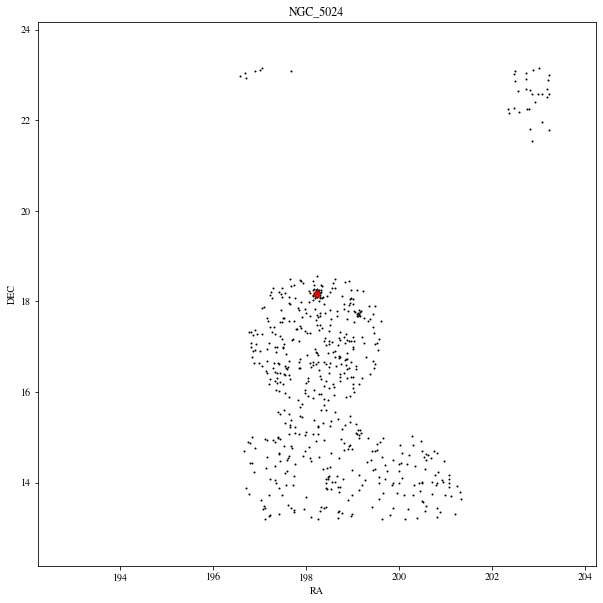


The final amount of stars in our sample is: 587
rhm: 0.03	rt: 0.55
There are [3, 35, 44, 52, 69] stars in our GC control group for a scale factor of ['1.00', '5.11', '9.23', '13.34', '17.46'] *rhm. Using 8*rhm gives 42
[ 11.812961     9.811803    25.677244   -23.156313   -24.316038
  15.696496    -8.127485    15.780737   -15.0327015   14.971171
  31.787197    29.336716    25.63785    -21.247042    23.579964
  24.931301    12.803774    34.223923   -16.152344    18.229033
  24.811823    14.510243    30.130215   -19.191296   -16.045242
 -18.173073   -24.141865    14.401118    10.924581   -28.619528
   2.5899575   11.455488    11.529113    29.911926    31.794083
 -23.092796    -0.10372884 -20.636757   -24.849726    26.97745
   9.92859     -3.9886138   17.106403    -6.2933755   24.913446
   2.533395   -10.691861    19.022303    -8.91425     11.575637
  33.57517     27.148005   -10.582854   -27.308329    25.757952
  -2.3097253  -24.55941     -2.338694    21.417341   -13.238723
 -18.768524  

AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

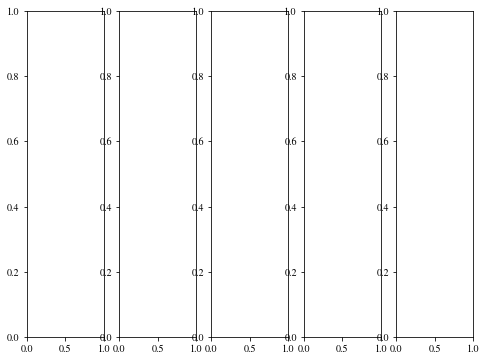

In [252]:
start = time.time()

for count, i in enumerate(GC_name_list[25:30]):
    GC_stars_dict[i] = master_func_auto(i, all_param_dict, fov, GC_db, apogee_nofilt, param_list, ML_index)
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')

### Breaking up the dictionary into individual arrays of stars in ML space

In [212]:
print(len(GC_stars_dict))

#GC_name_list = []
control_stars_list = []
total_stars_list = []


for key in GC_stars_dict:
    #GC_name_list.append(key)
    if GC_stars_dict[key][0] is None:
        control_stars_list.append(0)
        total_stars_list.append(0)
    else:
        control_stars_list.append(len(GC_stars_dict[key][2]))
        total_stars_list.append(len(GC_stars_dict[key][0]))
    
print(control_stars_list)
print(len(GC_name_list))

30
[5, 5, 5, 5, 0, 5, 0, 0, 5, 5, 5, 5, 5, 0, 5, 0, 5, 5, 0, 0, 5, 0, 5, 5, 0, 0, 5, 5, 5, 5]
159


In [213]:
new_control_stars_list = []
new_total_stars_list = []
new_stars_index_list = []

for i in range(len(control_stars_list)):
    #print(control_stars_list[i])
    if control_stars_list[i] != 0:
        new_control_stars_list.append(control_stars_list[i])
        new_total_stars_list.append(total_stars_list[i])
        new_stars_index_list.append(i)
        
print(len(new_stars_index_list))

20


In [214]:
print(new_stars_index_list)

[0, 1, 2, 3, 5, 8, 9, 10, 11, 12, 14, 16, 17, 20, 22, 23, 26, 27, 28, 29]


In [215]:
GC_name_arr = np.empty(len(new_stars_index_list), dtype=np.ndarray)

tsne_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

umap_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

In [216]:
'''for i in range(len(new_stars_index_list)):
    ind = new_stars_index_list[i]
    #print(ind)
    GC_name_arr[i] = GC_name_list[i]
    
    tsne_control_X[i] = GC_stars_dict[GC_name_list[ind]][2]
    tsne_control_Y[i] = GC_stars_dict[GC_name_list[ind]][3]
    tsne_all_X[i] = GC_stars_dict[GC_name_list[ind]][0]
    tsne_all_Y[i] = GC_stars_dict[GC_name_list[ind]][1]
    
    umap_control_X[i] = GC_stars_dict[GC_name_list[ind]][7]
    umap_control_Y[i] = GC_stars_dict[GC_name_list[ind]][6]
    umap_all_X[i] = GC_stars_dict[GC_name_list[ind]][4]
    umap_all_Y[i] = GC_stars_dict[GC_name_list[ind]][5]'''

'for i in range(len(new_stars_index_list)):\n    ind = new_stars_index_list[i]\n    #print(ind)\n    GC_name_arr[i] = GC_name_list[i]\n    \n    tsne_control_X[i] = GC_stars_dict[GC_name_list[ind]][2]\n    tsne_control_Y[i] = GC_stars_dict[GC_name_list[ind]][3]\n    tsne_all_X[i] = GC_stars_dict[GC_name_list[ind]][0]\n    tsne_all_Y[i] = GC_stars_dict[GC_name_list[ind]][1]\n    \n    umap_control_X[i] = GC_stars_dict[GC_name_list[ind]][7]\n    umap_control_Y[i] = GC_stars_dict[GC_name_list[ind]][6]\n    umap_all_X[i] = GC_stars_dict[GC_name_list[ind]][4]\n    umap_all_Y[i] = GC_stars_dict[GC_name_list[ind]][5]'

In [217]:
new_stars_index_list

[0, 1, 2, 3, 5, 8, 9, 10, 11, 12, 14, 16, 17, 20, 22, 23, 26, 27, 28, 29]

In [218]:
GC_name_list

0        NGC_104
1        NGC_288
2        NGC_362
3      Whiting_1
4       NGC_1261
         ...    
154     NGC_7089
155     NGC_7099
156      Pal_12 
157       Pal_13
158     NGC_7492
Name: Cluster, Length: 159, dtype: object

In [219]:
for i in range(len(new_stars_index_list)):
    ind = new_stars_index_list[i]
    #print(ind)
    GC_name_arr[i] = GC_name_list[ind]
    
    tsne_control_X[i] = GC_stars_dict[GC_name_arr[i]][2]
    tsne_control_Y[i] = GC_stars_dict[GC_name_arr[i]][3]
    tsne_all_X[i] = GC_stars_dict[GC_name_arr[i]][0]
    tsne_all_Y[i] = GC_stars_dict[GC_name_arr[i]][1]
    
    umap_control_X[i] = GC_stars_dict[GC_name_arr[i]][7]
    umap_control_Y[i] = GC_stars_dict[GC_name_arr[i]][6]
    umap_all_X[i] = GC_stars_dict[GC_name_arr[i]][4]
    umap_all_Y[i] = GC_stars_dict[GC_name_arr[i]][5]

In [220]:
len(tsne_control_X)

20

In [221]:
print([len(i) for i in tsne_all_X])
for i in umap_control_X:
    for j in range(len(i)):
        print([len(j) for j in i])

[467, 287, 1215, 1187, 338, 2091, 307, 246, 413, 1749, 565, 1350, 1064, 1186, 279, 307, 587, 628, 1680, 1891]
[155, 165, 170, 178, 185]
[155, 165, 170, 178, 185]
[155, 165, 170, 178, 185]
[155, 165, 170, 178, 185]
[155, 165, 170, 178, 185]
[84, 110, 125, 144, 155]
[84, 110, 125, 144, 155]
[84, 110, 125, 144, 155]
[84, 110, 125, 144, 155]
[84, 110, 125, 144, 155]
[61, 66, 71, 88, 104]
[61, 66, 71, 88, 104]
[61, 66, 71, 88, 104]
[61, 66, 71, 88, 104]
[61, 66, 71, 88, 104]
[0, 6, 24, 44, 56]
[0, 6, 24, 44, 56]
[0, 6, 24, 44, 56]
[0, 6, 24, 44, 56]
[0, 6, 24, 44, 56]
[1, 3, 9, 20, 33]
[1, 3, 9, 20, 33]
[1, 3, 9, 20, 33]
[1, 3, 9, 20, 33]
[1, 3, 9, 20, 33]
[0, 1, 8, 15, 32]
[0, 1, 8, 15, 32]
[0, 1, 8, 15, 32]
[0, 1, 8, 15, 32]
[0, 1, 8, 15, 32]
[116, 147, 180, 197, 215]
[116, 147, 180, 197, 215]
[116, 147, 180, 197, 215]
[116, 147, 180, 197, 215]
[116, 147, 180, 197, 215]
[60, 107, 157, 213, 246]
[60, 107, 157, 213, 246]
[60, 107, 157, 213, 246]
[60, 107, 157, 213, 246]
[60, 107, 157, 213, 

In [229]:
fig, ax = plt.subplots(len(tsne_all_X), len(tsne_control_X[0]) * 2, figsize=(len(tsne_control_X) * 6, 6 * len(tsne_all_X)))

for i in range(len(tsne_all_X)):
    for j in range(len(tsne_control_X[i])):
        # tSNE
        ax[i][j].scatter(GC_stars_dict[GC_name_arr[i]][0], GC_stars_dict[GC_name_arr[i]][1], s=1, c='gray') # all
        ax[i][j].scatter(GC_stars_dict[GC_name_arr[i]][2][j], GC_stars_dict[GC_name_arr[i]][3][j], s=45, edgecolor='k', c='hotpink') # control
        ax[i][j].set_title(GC_name_list[i] + ' tSNE for ' + str(len(tsne_control_X[i][j])) + ' control stars')
        ax[i][j].set_xlabel('tSNE X')
        ax[i][j].set_ylabel('tSNE Y')

        # UMAP
        ax[i][j + len(tsne_control_X[i])].scatter(GC_stars_dict[GC_name_arr[i]][4], GC_stars_dict[GC_name_arr[i]][5], s=1, c='gray') # all
        ax[i][j + len(tsne_control_X[i])].scatter(GC_stars_dict[GC_name_arr[i]][6][j], GC_stars_dict[GC_name_arr[i]][7][j], s=45, edgecolor='k', c='hotpink') # control
        ax[i][j + len(tsne_control_X[i])].set_title(GC_name_list[i] + ' UMAP for ' + str(len(umap_control_X[i][j])) + ' control stars')
        ax[i][j + len(tsne_control_X[i])].set_xlabel('UMAP X')
        ax[i][j + len(tsne_control_X[i])].set_ylabel('UMAP Y')
                           
plt.tight_layout()
plt.savefig('goodness_Gracious.png')
plt.show()

In [ ]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

fig, ax = plt.subplots(17, 5, figsize=(40, 120))
for i in range(17):
    for j in range(5//2):
        # tSNE
        ax[i, 2 * j].scatter(GC_stars_dict[GC_name_list[i + j * 5]][0], GC_stars_dict[GC_name_list[i + j * 5]][1], s=1, c='gray') # all
        ax[i, 2 * j].scatter(GC_stars_dict[GC_name_list[i + j * 5]][2], GC_stars_dict[GC_name_list[i + j * 5]][3], s=45, edgecolor='k', c='hotpink') # control
        ax[i, 2 * j].set_title(GC_name_list[i + j * 5] + ' tSNE')
        ax[i, 2 * j].set_xlabel('tSNE X')
        ax[i, 2 * j].set_ylabel('tSNE Y')
        # UMAP
        ax[i, 2 * j + 1].scatter(GC_stars_dict[GC_name_list[i + j * 5]][4], GC_stars_dict[GC_name_list[i + j * 5]][5], s=1, c='gray') # all
        ax[i, 2 * j + 1].scatter(GC_stars_dict[GC_name_list[i + j * 5]][6], GC_stars_dict[GC_name_list[i + j * 5]][7], s=45, edgecolor='k', c='hotpink') # control
        ax[i, 2 * j + 1].set_title(GC_name_list[i + j * 5] + ' UMAP')
        ax[i, 2 * j + 1].set_xlabel('UMAP X')
        ax[i, 2 * j + 1].set_ylabel('UMAP Y')
        
        
plt.tight_layout()
#plt.savefig('all_ML.png')
plt.show()

### Plotting all ML shit

In [ ]:
point_size_list = []
for i in control_stars_list:
    if i <= 25:
        point_size_list.append(500 + i * 50)
    elif i > 25 and i <= 50:
        point_size_list.append(1500 + i * 50)
    elif i > 50 and i <= 100:
        point_size_list.append(3000 + i * 50)
    elif i > 100:
        point_size_list.append(5000 + i * 50)

In [ ]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 50}

plt.rc('font', **font)

plt.figure(figsize=(60,40))
plt.plot(apogee_nofilt.RA, apogee_nofilt.DEC.values, 'ok', markersize=1, alpha=0.5)
plt.scatter(GC_ra_list, GC_dec_list, color='r', s=point_size_list, edgecolor='k', linewidth=3)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.title('Plot of the APOGEE dataset stars and GC cluster central location based on control group size')
plt.savefig('GC_map.png')

#### Warning: Only run this block below if you have a beefy computer or if you wanna experience MS slideshow

In [ ]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

fig, ax = plt.subplots(23, 14, figsize=(230, 200))
for i in range(23):
    for j in range(7):
        # tSNE
        ax[i, 2 * j].scatter(GC_stars_dict[GC_name_list[i + j * 14]][0], GC_stars_dict[GC_name_list[i + j * 14]][1], s=1, c='gray') # all
        ax[i, 2 * j].scatter(GC_stars_dict[GC_name_list[i + j * 14]][2], GC_stars_dict[GC_name_list[i + j * 14]][3], s=45, edgecolor='k', c='hotpink') # control
        ax[i, 2 * j].set_title(GC_name_list[i + j * 14] + ' tSNE')
        ax[i, 2 * j].set_xlabel('tSNE X')
        ax[i, 2 * j].set_ylabel('tSNE Y')
        # UMAP
        ax[i, 2 * j + 1].scatter(GC_stars_dict[GC_name_list[i + j * 14]][4], GC_stars_dict[GC_name_list[i + j * 14]][5], s=1, c='gray') # all
        ax[i, 2 * j + 1].scatter(GC_stars_dict[GC_name_list[i + j * 14]][6], GC_stars_dict[GC_name_list[i + j * 14]][7], s=45, edgecolor='k', c='hotpink') # control
        ax[i, 2 * j + 1].set_title(GC_name_list[i + j * 14] + ' UMAP')
        ax[i, 2 * j + 1].set_xlabel('UMAP X')
        ax[i, 2 * j + 1].set_ylabel('UMAP Y')
        
        
plt.tight_layout()
plt.savefig('all_ML.png')
plt.show()

In [ ]:
plt.hist(total_stars_list, bins=20, color='k')
plt.hist(control_stars_list, bins=5, color='r', alpha=0.5)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(GC_name_list, total_stars_list, 'ok', markersize=1)
plt.plot(GC_name_list, control_stars_list, 'or', markersize=1)
plt.show()

## Indentifying clusters

### Using the radius method to look for neighbouring candidates until none are found for n tries

We have control group stars located. What we wanna do is we wanna find a radius for the control group and take all stars that are extratidal within that radii. So the radius drawn should be drawn until there are no more control group stars for n tries.

Should we start with a set cluster of control group members? or run the search on all control group members and see which ones has the most?

In [ ]:
tsne_control_X

## old stuff

Parameters for GCs

In [ ]:
# M3 (NGC 5272)
ra_M3 = 205.54842 # [deg]
dec_M3 = 28.37728 # [deg]
dist_M3 = 10180  # [pc]
rt_M3 = 159.0339  # [pc] -- tidal radius @ apogalacticon
rhm_M3 = 6.34  # [pc]
rhm_M3_deg = math.degrees(math.atan(rhm_M3 / dist_M3))  # deg
pmra_M3 = -0.152  # [mas/yr]
pmdec_M3 = -2.670  # [mas/yr]

# M13 (NGC 6205)
ra_M13 = 250.42181
dec_M13 = 36.45986
dist_M13 = 7420
rt_M13 = 8640
rhm_M13 = 5.26
rhm_M13_deg = math.degrees(math.atan(rhm_M13 / dist_M13))  # deg

# M2 (NGC 7089)
ra_M2 = 323.36258
dec_M2 = -0.82325
dist_M2 = 11690
rt_M2 = 10540
rhm_M2 = 4.77
rhm_M2_deg = math.degrees(math.atan(rhm_M2 / dist_M2))  # deg

# M12 (NGC 6218)
ra_M12 = 251.80907
dec_M12 = -1.94853
dist_M12 = 5110
rt_M12 = 4570
rhm_M12 = 4.05
rhm_M12_deg = math.degrees(math.atan(rhm_M12 / dist_M12))  # deg

# M10 (NGC 6254)
ra_M10 = 254.28772
dec_M10 = -4.10031
dist_M10 = 5070
rt_M10 = 4350
rhm_M10 = 4.81
rhm_M10_deg = math.degrees(math.atan(rhm_M10 / dist_M10))  # deg

# NGC 6397
ra_NGC6397 = 265.17538
dec_NGC6397 = -53.67434
dist_NGC6397 = 2480
rt_NGC6397 = 6010
rhm_NGC6397 = 3.90
rhm_NGC6397_deg = math.degrees(math.atan(rhm_NGC6397 / dist_NGC6397))  # deg

In [ ]:
plt.figure(figsize=(40,40))
plt.plot(apogee_nofilt['RA'].values, apogee_nofilt['DEC'].values, 'ok', linewidth=1, linestyle='none')
plt.plot(ra_M3, dec_M3, 'or', markersize=25)
plt.plot(ra_M13, dec_M13, 'or', markersize=25)
plt.plot(ra_M2, dec_M2, 'or', markersize=25)
plt.plot(ra_M10, dec_M10, 'or', markersize=25)
plt.plot(ra_NGC6397, dec_NGC6397, 'or', markersize=25)

#### M3
NGC_5272

In [ ]:
M3_tSNE_X, M3_tSNE_Y, M3_tSNE_control_X, M3_tSNE_control_Y, M3_UMAP_X, M3_UMAP_Y, M3_UMAP_control_X, M3_UMAP_control_Y = master_func(all_param_dict, fov, GC_db, apogee_nofilt, param_list, ML_index)

#### M13

In [ ]:
M13_tSNE_X, M13_tSNE_Y, M13_tSNE_control_X, M13_tSNE_control_Y, M13_UMAP_X, M13_UMAP_Y, M13_UMAP_control_X, M13_UMAP_control_Y = master_func(ra_M13, dec_M13, rhm_M13_deg, all_param_dict, fov, apogee_nofilt, param_list, ML_index)

#### M2

In [ ]:
M2_tSNE_X, M2_tSNE_Y, M2_tSNE_control_X, M2_tSNE_control_Y, M2_UMAP_X, M2_UMAP_Y, M2_UMAP_control_X, M2_UMAP_control_Y = master_func(ra_M2, dec_M2, rhm_M2_deg, all_param_dict, fov, apogee_nofilt, param_list, ML_index)

#### M12

In [ ]:
M12_tSNE_X, M12_tSNE_Y, M12_tSNE_control_X, M12_tSNE_control_Y, M12_UMAP_X, M12_UMAP_Y, M12_UMAP_control_X, M12_UMAP_control_Y = master_func(ra_M12, dec_M12, rhm_M12_deg, all_param_dict, fov, apogee_nofilt, param_list, ML_index)

#### M10

In [ ]:
M10_tSNE_X, M10_tSNE_Y, M10_tSNE_control_X, M10_tSNE_control_Y, M10_UMAP_X, M10_UMAP_Y, M10_UMAP_control_X, M10_UMAP_control_Y = master_func(ra_M10, dec_M10, rhm_M10_deg, all_param_dict, fov, apogee_nofilt, param_list, ML_index)

#### NGC6397

In [ ]:
NGC6397_tSNE_X, NGC6397_tSNE_Y, NGC6397_tSNE_control_X, NGC6397_tSNE_control_Y, NGC6397_UMAP_X, NGC6397_UMAP_Y, NGC6397_UMAP_control_X, NGC6397_UMAP_control_Y = master_func(ra_NGC6397, dec_NGC6397, rhm_NGC6397_deg, all_param_dict, fov, apogee_nofilt, param_list, ML_index)

## Below is random shit ive been playing around with, you can ignore or continue playing around with

#### Changing Perplexity (default 30)
related to # of nearby neighbours. Not sure what specifically

In [234]:
### Perplexity changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# perplexity list (default 30)
perp_list = [5, 10, 15, 20, 25, 35, 40, 45, 50]
t_SNE_dimX_perp = []
t_SNE_dimY_perp = []
tsne_dimX_control_perp = []
tsne_dimY_control_perp = []
for i in perp_list:
    tsne_init_perp = TSNE(n_components=2, perplexity=i)
    tsne_2d_perp = tsne_init_perp.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_perp.append(tsne_2d_perp[:, 0])
    t_SNE_dimY_perp.append(tsne_2d_perp[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_perp.append(t_SNE_dimX_perp[-1][indices_control])
    tsne_dimY_control_perp.append(t_SNE_dimY_perp[-1][indices_control])
    
    print('t_SNE done for perp =', i)

print('t_SNE done')

NameError: name 'standardized_array' is not defined

In [ ]:
fig_perp, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_perp[i + 3 * j], t_SNE_dimY_perp[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_perp[i + 3 * j], tsne_dimY_control_perp[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for perp =' + str(perp_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_list[i + 3*j]), 'Control: ', len(tsne_dimX_control_list[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_perp')
plt.show()



Seems like the higher the perplexity, the more tightly grouped together the control stars. After 20 there seems to be a drop off in terms of cluster tightness increase. Running the same code doesn't yield the same graphs?

#### Changing early exaggeration (default 12)
controls tightness of natural clusters and how much space will be in between them?

In [ ]:
### early exaggeration changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# early exaggeration list (default 12.)
exg_list = [4., 8., 16., 20., 24., 28., 32., 36., 40.]
t_SNE_dimX_exg = []
t_SNE_dimY_exg = []
tsne_dimX_control_exg = []
tsne_dimY_control_exg = []
for i in exg_list:
    tsne_init_exg = TSNE(n_components=2, perplexity=i)
    tsne_2d_exg = tsne_init_exg.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_exg.append(tsne_2d_exg[:, 0])
    t_SNE_dimY_exg.append(tsne_2d_exg[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_exg.append(t_SNE_dimX_exg[-1][indices_control])
    tsne_dimY_control_exg.append(t_SNE_dimY_exg[-1][indices_control])
    
    print('t_SNE done for exg =', i)

print('t_SNE done')

In [ ]:
fig_exg, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_exg[i + 3 * j], t_SNE_dimY_exg[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_exg[i + 3 * j], tsne_dimY_control_exg[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for early exg =' + str(exg_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_exg[i + 3*j]), 'Control: ', len(tsne_dimX_control_exg[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_exg')
plt.show()



Seems like higher early exaggeration leads to tighter groups. Just like perplexity, there seems to be a falloff in group tightness increase

#### Changing learning rate (default 200)
something to do with step size and optimization for ML algorithms i think

In [ ]:
### early exaggeration changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# early exaggeration list (default 12.)
learn_list = [10., 100., 300., 400., 500., 600., 700., 800., 900.]
t_SNE_dimX_learn = []
t_SNE_dimY_learn = []
tsne_dimX_control_learn = []
tsne_dimY_control_learn = []
for i in learn_list:
    tsne_init_learn = TSNE(n_components=2, learning_rate=i)
    tsne_2d_learn = tsne_init_learn.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_learn.append(tsne_2d_learn[:, 0])
    t_SNE_dimY_learn.append(tsne_2d_learn[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_learn.append(t_SNE_dimX_learn[-1][indices_control])
    tsne_dimY_control_learn.append(t_SNE_dimY_learn[-1][indices_control])
    
    print('t_SNE done for learn =', i)

print('t_SNE done')

In [ ]:
fig_learn, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_learn[i + 3 * j], t_SNE_dimY_learn[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_learn[i + 3 * j], tsne_dimY_control_learn[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for learning rate =' + str(exg_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_exg[i + 3*j]), 'Control: ', len(tsne_dimX_control_exg[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_learn')
plt.show()

Not too much noticable change surprisingly.

### OVerall remarks

Seems to have a similar structure each time, just different control group locations and orientations

#### Improving the Dimensionality Reduction
Fine tune the hyper-parameters:
- understand how the different hyper-parameters affect the data
- what combination of hyper-parameters achieve the best separation of the control group? to acheive the best 

Helpful Papers:

https://distill.pub/2016/misread-tsne/ 

https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868 

Dimensional Reduction Astronomy Example:
https://arxiv.org/pdf/2210.02471.pdf
